<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

The files consist of a list of product listings. These files are tab-delimited.

- train_id or test_id - the id of the listing
- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
Please note that in stage 1, all the test data will be calculated on the public leaderboard. In stage 2, we will swap the test.tsv file to the complete test dataset that includes the private leaderboard data.

翻译  
- train_id 是数据id
- name 是商品名
- item_condition_id 是卖方提供的物品状况
- category_name 是商品类别
- brand_name 是品牌
- price 是价格也就是我们要预测的y
- shipping 是是否包邮
- item_description 是买家评价

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import string

%matplotlib inline

In [2]:
train = pd.read_table('data/train.tsv', engine='c')
test = pd.read_table('data/test.tsv', engine='c')

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [4]:
print('训练集大小:{}\n测试集大小:{}'.format(train.shape, test.shape))

训练集大小:(1482535, 8)
测试集大小:(693359, 7)


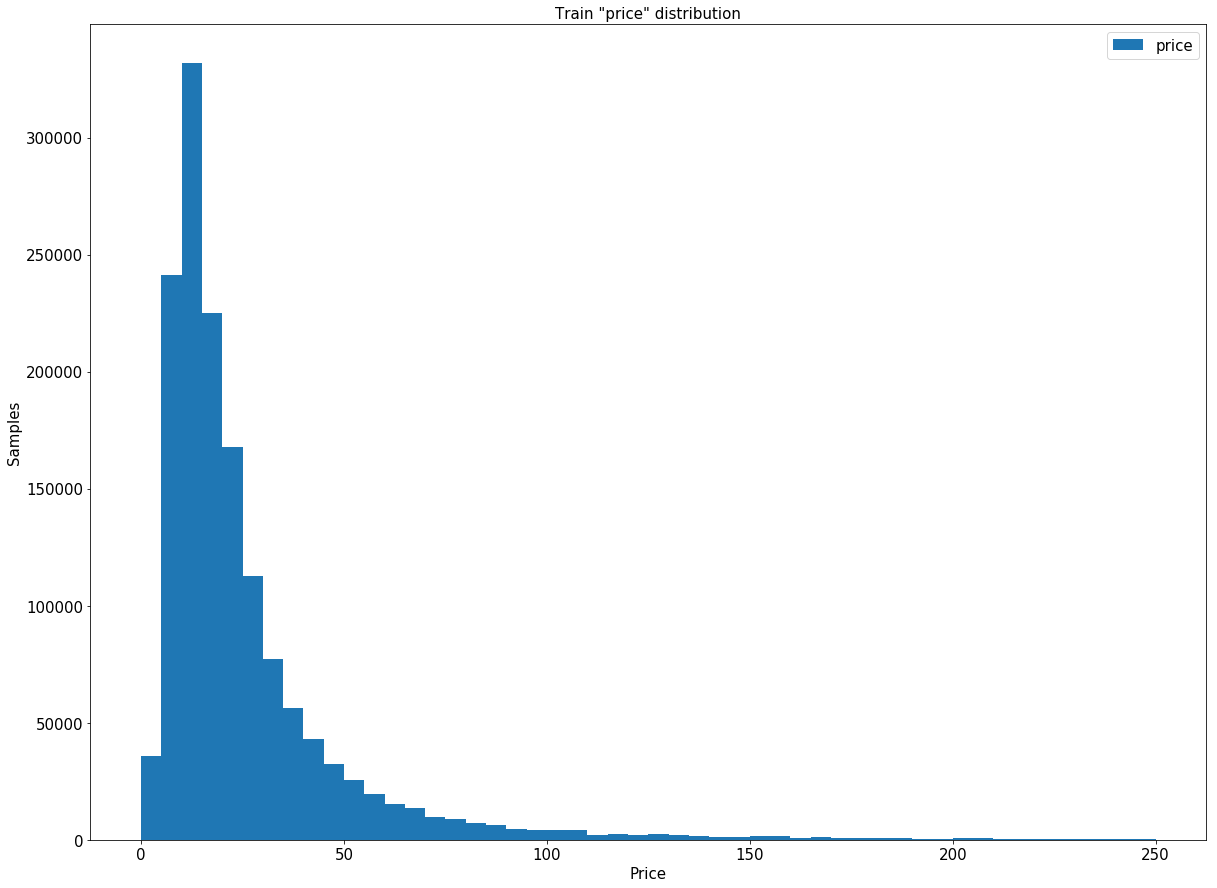

In [7]:
plt.figure(figsize=(20, 15))
plt.hist(train['price'], bins=50, range=[0,250], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

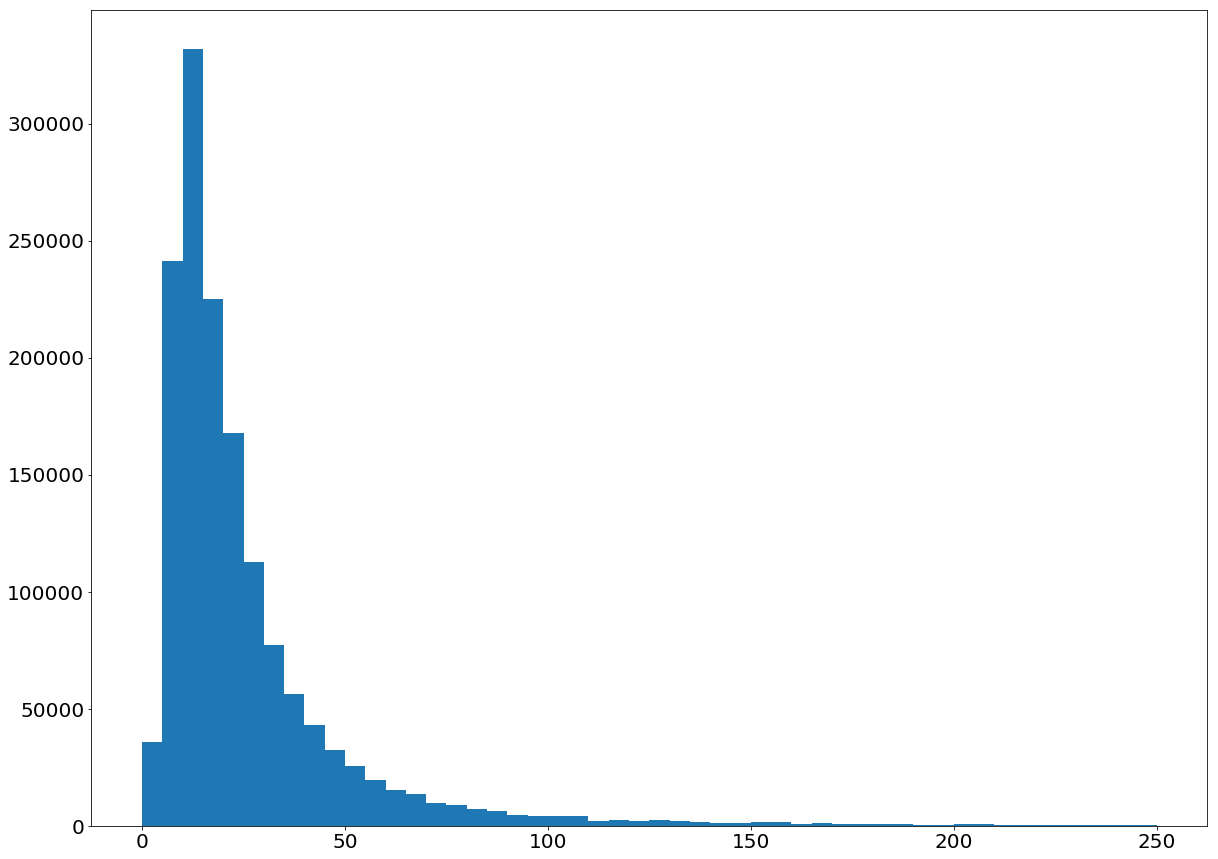

In [16]:
plt.figure(figsize=(20, 15))
train.price.hist(grid=False, bins=50, xlabelsize=20, ylabelsize=20, range=[0,250])

In [17]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

e:\workspace\env_prnet_366\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


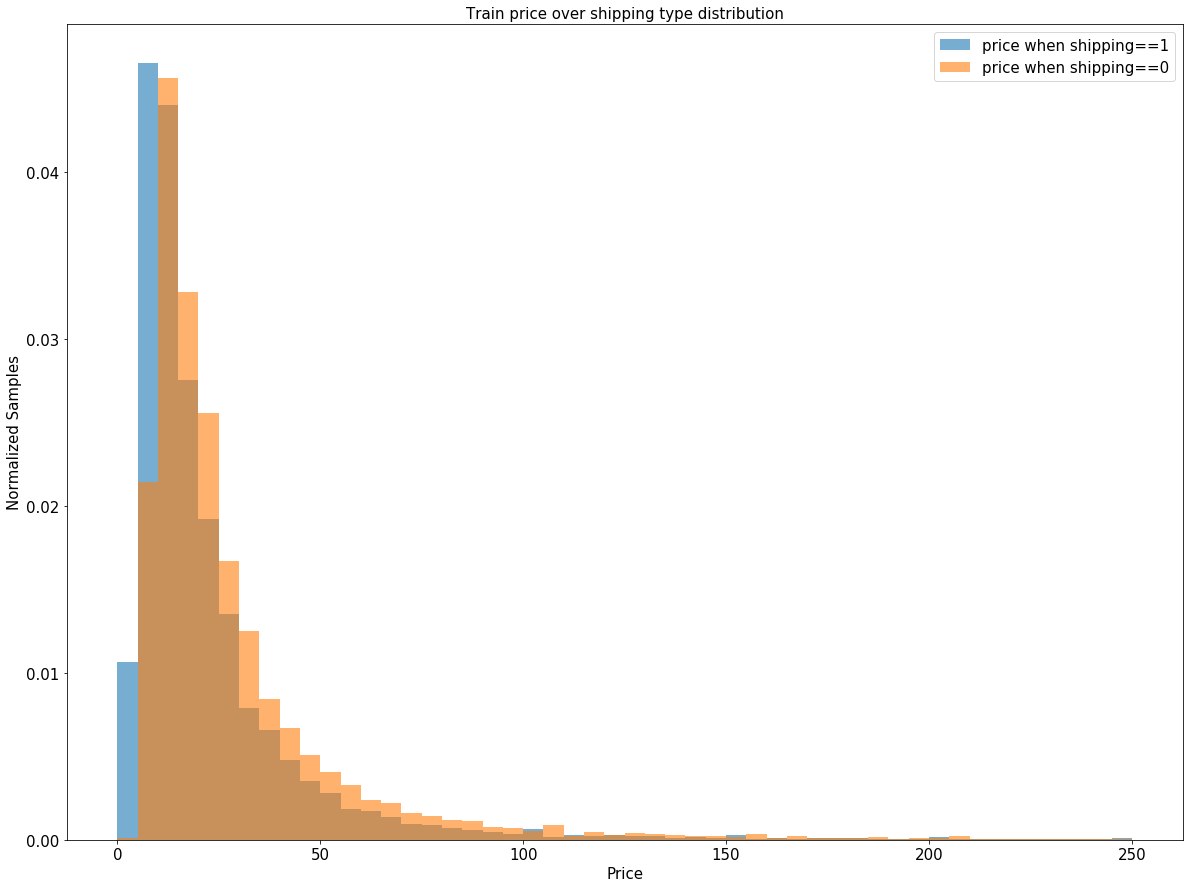

In [18]:
plt.figure(figsize=(20, 15))
bins=50
plt.hist(train[train['shipping']==1]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='price when shipping==1')
plt.hist(train[train['shipping']==0]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='price when shipping==0')
plt.title('Train price over shipping type distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Normalized Samples', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [26]:
train['y_train'] = np.log1p(train['price'])
train['category_name'] = train['category_name'].fillna('Other').astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['item_description'] = train['item_description'].fillna('None')

In [27]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,y_train
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,3.806662


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 9 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null object
category_name        1482535 non-null object
brand_name           1482535 non-null object
price                1482535 non-null float64
shipping             1482535 non-null object
item_description     1482535 non-null object
y_train              1482535 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 101.8+ MB


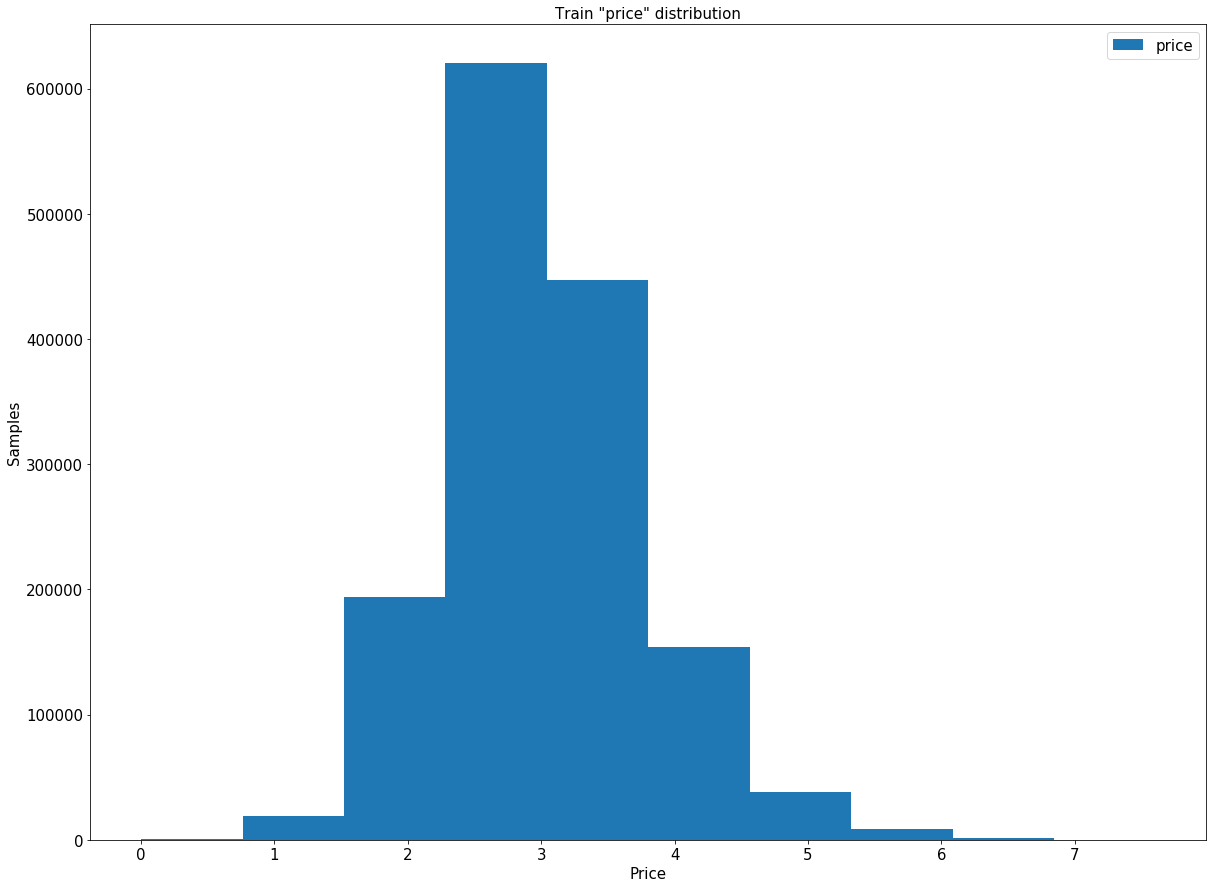

In [36]:
plt.figure(figsize=(20, 15))
plt.hist(train['y_train'], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [37]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    
vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=5000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=5000,
        preprocessor=build_preprocessor('item_description'))),
])
X_train = vectorizer.fit_transform(train.values)
X_train

<1482535x16105 sparse matrix of type '<class 'numpy.float64'>'
	with 50819218 stored elements in Compressed Sparse Row format>

In [41]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = get_rmsle(y_pred_valid, y_train[valid_ids])
    print(f'valid rmsle: {rmsle:.5f}')
    break

valid rmsle: 0.48815


算法精确准确率并不高, 我们可以调高 在文本哑变量化中TfidfVectorizer 的max_feature 参数的值
单个ridge模型的准确率不行这时我们就可以用lightgbm了.进行多个模型组合具体可以看代码文件